In [519]:
import pandas as pd
import numpy as np
import glob
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from datetime import datetime as dt
import unidecode
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import string

import re
import pickle

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import hstack
from scipy.special import logit, expit

# from my_nmf import NMF
from helpers import build_text_vectorizer, hand_label_topics, analyze_article

plt.style.use('seaborn')
# os.chdir("data")

In [499]:
file = 'data/comments.csv'
df = pd.read_csv(file, names = ['Text', 'ID', 'Subreddit', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes', 'Author_link_karma', 'Author_Comment_Karma','Author_has_gold?'], parse_dates =True, encoding = 'utf-8')


In [512]:
df2 = df.copy()

In [513]:
df_entertainment = df2.dropna(axis =0).loc[df2['meta']== 'entertainment']
df_entertainment.Text

1446458    i can not wait to see him whoop some intergala...
1446459    amazing cinematographer. one of the best to ev...
1446463              you 've finally had your life changed .
1446464                           that is awesome ! thanks !
1446465    that tom cruise 's character , john anderton ,...
                                 ...                        
1826308                                      i love it ! ! !
1826309    you are the type of ra i hope i can be if i ma...
1826310    this was my bulletin board for the month too :...
1826311    that 's so excellent ! i would be so pleased t...
1826312    when i was an ra , my favorite bulletin board ...
Name: Text, Length: 357672, dtype: object

# Proper Pipeline, no alaska

In [506]:
# v's are randomly being deleted from my text data in an unpredictable way, is there any way to stop that?

# array1

In [514]:
def clean_urls(array):
    lst = []
    for string in array:
#         print(string)
        if string > re.sub(r'(https|http)? : \/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE):
            string = re.sub(r'(https|http)? : \/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE)
#             print(string)
            string = re.sub(r'v = () ', '', string, flags = re.MULTILINE)
            lst.append(string)
        else: 
            string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE)
            lst.append(string)
    return lst
# test
cleaned_urls = clean_urls(df_entertainment.Text.values)
cleaned_urls
# type(cleaned_urls[1])

['i can not wait to see him whoop some intergalactic alien butt in rogue one. or whoop anyone in anything really .',
 'amazing cinematographer. one of the best to ever do it .',
 "you 've finally had your life changed .",
 'that is awesome ! thanks !',
 "that tom cruise 's character , john anderton , kidnaps the pre-cog agatha in a pool , mirroring his own son 's kidnapping , which was also by a pool . there is also the irony in that he joined precrime to stop incidences like his son 's kidnapping. yet he resorts to kidnapping afterwards in order to prove that the system he worked so hard to develop was wrong . great movie !",
 "dear. god. that was one of the most incredible movies i 've ever seen , going into it i knew only a few things. that it takes place in world where women have become infertile and one woman has become pregnant , clive owen must guide her to safety. there 's a long take in a car and julianne moore gets shot. yeah , it sucks that that part got spoiled for me but i

In [541]:
punctuations = '''.!=-()[]{};:"|\<>/?@#$%^&*_~'''
replace = '{}'.format('\n')
lst = []

test_strings = ['James ran ForWard from the https:// youtube.com v asfhabjf v asvjdakbfakdfasdfbasdfadfsasfadga %666^^ 32$']
test_strings2 = df_entertainment.Text.values[:2]
# print(test_strings2)

def base_clean_up(strings):
    new_strings = [] 
    for i in strings:
#         i = clean_urls(i)
#         print(i)
        i = i.lower()
#         print(i)
        i = unidecode.unidecode(i)
#         print(i)
        no_punct = ""
        for word in i.split():
            
            word = re.sub(r'[^\w\s]','',word)
            if len(word) > 20:
                word = ""
            no_punct += f'{word} '
        new_strings.append(no_punct)
#         print(no_punct)
    return new_strings



# # test check
# clean_test = base_clean_up(test_strings2)
# print(clean_test)
# check using df
base_clean_up1 = base_clean_up(cleaned_urls)  
base_clean_up1
# clean_test

['i can not wait to see him whoop some intergalactic alien butt in rogue one. or whoop anyone in anything really .'
 'amazing cinematographer. one of the best to ever do it .']


['i can not wait to see him whoop some intergalactic alien butt in rogue one or whoop anyone in anything really  ',
 'amazing cinematographer one of the best to ever do it  ',
 'you ve finally had your life changed  ',
 'that is awesome  thanks  ',
 'that tom cruise s character  john anderton  kidnaps the precog agatha in a pool  mirroring his own son s kidnapping  which was also by a pool  there is also the irony in that he joined precrime to stop incidences like his son s kidnapping yet he resorts to kidnapping afterwards in order to prove that the system he worked so hard to develop was wrong  great movie  ',
 'dear god that was one of the most incredible movies i ve ever seen  going into it i knew only a few things that it takes place in world where women have become infertile and one woman has become pregnant  clive owen must guide her to safety there s a long take in a car and julianne moore gets shot yeah  it sucks that that part got spoiled for me but i was in shock it happened

In [542]:
def tokenizer(strings):
        lst = []
        for i in strings:
            tokens = [word for word in i if word not in s_stop]
            lst.append(tokens)
        return lst

# # test tokenizer 
test_tokes = tokenizer(base_clean_up1)
print(test_tokes)
#     lst.append(no_punct)
# df_entertainment.Text = lst

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [457]:
def lemmatization(tokens):
#     for i in tokens:
    
    lems = [[lemmatizer.lemmatize(word) for word in sent] for sent in tokens]
    return lems
lemmatization(test_tokes)


[['wait',
  'see',
  'whoop',
  'intergalactic',
  'alien',
  'butt',
  'rogue',
  'whoop',
  'anyone',
  'anything',
  'really'],
 ['amazing', 'cinematographer', 'best'],
 ['finally', 'life', 'changed'],
 ['awesome', 'thanks'],
 ['tom',
  'cruise',
  'character',
  'john',
  'anderton',
  'kidnaps',
  'precog',
  'agatha',
  'pool',
  'mirroring',
  'kidnapping',
  'pool',
  'irony',
  'joined',
  'precrime',
  'stop',
  'incidence',
  'like',
  'kidnapping',
  'yet',
  'resort',
  'kidnapping',
  'afterwards',
  'order',
  'pro',
  'system',
  'worked',
  'hard',
  'elop',
  'wrong',
  'great',
  'mo',
  'ie']]

In [507]:
def pipe1(array):
    strings = clean_urls(array)
    strings = base_clean_up(array1)    
    tokens = tokenizer(strings)
    lems = lemmatization(tokens)
    return lems
# # piped_1 = pipe1(array1)
# piped_2 = pipe2(strings)
# (piped_2
new_vals = pipe1(df_entertainment.Text.values)


In [510]:
len(new_vals)

5

In [244]:

df_test = df2.copy()
for i in range(0, 600):
    print(df_entertainment.Text.values[i])
len('wallpaperkurosakiichigo290694271024768jpg')

   i can not wait to see him whoop some intergalactic alien butt in rogue one or whoop anyone in anything really 
   amazing cinematographer one of the best to e er do it 
   you  e finally had your life changed 
   that is awesome  thanks 
   that tom cruise s character , john anderton , kidnaps the precog agatha in a pool , mirroring his own son s kidnapping , which was also by a pool  there is also the irony in that he joined precrime to stop incidences like his son s kidnapping yet he resorts to kidnapping afterwards in order to pro e that the system he worked so hard to de elop was wrong  great mo ie 
   dear god that was one of the most incredible mo ies i  e e er seen , going into it i knew only a few things that it takes place in world where women ha e become infertile and one woman has become pregnant , cli e owen must guide her to safety there s a long take in a car and julianne moore gets shot yeah , it sucks that that part got spoiled for me but i was in shock it happened s

41

In [12]:
df_test



,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaimer : i think obama should nominate som...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way the process will be dragged out unt...,d026od6,politics,news,1.455648e+09,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republicans have always battled with severe ca...,d026wk3,politics,news,1.455649e+09,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,politics were so different back then. people o...,d02a3k3,politics,news,1.455653e+09,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,"equally ridiculous , here 's a 1970 law review...",d025wad,politics,news,1.455647e+09,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,for those with a woefully bad sense of directi...,d02c1s1,minecraft,gaming,1.455656e+09,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,the characters hand in first person is invisib...,464kj4,minecraft,gaming,1.455656e+09,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,i guess either the shaders use some feature th...,d02cxvk,minecraft,gaming,1.455657e+09,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,my guess is that you 're trying to use a brand...,d02ic1n,minecraft,gaming,1.455664e+09,nothingl_,1.0,0.0,104.0,807.0,0.0


# pipeline


In [291]:
punctuations = '''.!=()[]{};:'"|\<>/?@#$%^&*_~'''
replace = '\n'


lst = []
for i in strings:
    no_punct = ""
#     if len(i) > 15:
#         continue
    for char in i:
        if char in replace:
            char = " "
        if char not in punctuations:
           no_punct = f'{no_punct + char }'
  
        
    lst.append(no_punct)
lst

['James ran ForWard from the v asvjdakbfakdfasdfbasdfadfsasfadga 666 32']

In [14]:
df_test.Text = lst
df_test

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaimer i think obama should nominate some...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way the process will be dragged out unt...,d026od6,politics,news,1.455648e+09,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republicans have always battled with severe ca...,d026wk3,politics,news,1.455649e+09,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,politics were so different back then people on...,d02a3k3,politics,news,1.455653e+09,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,"equally ridiculous , here s a 1970 law review ...",d025wad,politics,news,1.455647e+09,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,for those with a woefully bad sense of directi...,d02c1s1,minecraft,gaming,1.455656e+09,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,the characters hand in first person is invisib...,464kj4,minecraft,gaming,1.455656e+09,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,i guess either the shaders use some feature th...,d02cxvk,minecraft,gaming,1.455657e+09,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,my guess is that you re trying to use a brand ...,d02ic1n,minecraft,gaming,1.455664e+09,nothingl_,1.0,0.0,104.0,807.0,0.0


In [15]:
s_stop = set(stopwords.words())
new_stops = ['2015ref','publisherspage190ref','volume9', 'issue2', 'page7','logo.png','2015.ref', 'nameleaf200kcit','ref', '005.jpgthumbrightth', 'whose', 'kind','png', 'jpg', 'wiktionaryzero', 'wiktionaryzero0', 'wiktionaryzero0', 'articlesquantum','0supsup', '0refcit', '1-3', 'redirectzero', '.', ',', 'nameleaf200k2cit', 'wiktionari', 'namecarb01cit','-', 'filezero', 'mvaramvarxmvari', 'page98','datemfyes1915228', 'year1989ref', '1671.jpgthumbemerg', 'refimprovedatemay','ligatureligatur', 'pppc1expiry2144', 'wiktionary','wiktionary0', 'n','improvedateoctob' ]
for i in new_stops:
    s_stop.add(i)
len(s_stop)
new_stop = s_stop
len(new_stops)

41

In [413]:
# strings1 = df_entertainment.Text.values[:5]
lst_stems = []
for i in strings1:
    i = i.lower()
    i = unidecode.unidecode(i)
    l_s = sent_tokenize(i)
#     print("Sentence Tokens:\n",l_s[:2])

    tokens = list(map(word_tokenize, l_s))
#     print("\nWord Tokens:\n", tokens[:2])

    
    tokens_stop_free = [[word for word in sent if word not in s_stop] for sent in tokens]
#     print("\nNo stop word tokens:\n", tokens_stop_free[:2])

    st = SnowballStemmer(language = 'english')
    stems = [[st.stem(word) for word in sent] for sent in tokens_stop_free]
    try:
        stems_no_dupes = (stems[0])
    except:
        stems_no_dupes = stems
#     break
#     print("\nNo stop word tokens:\n", stems[:2])
    lst_stems.append(" ".join(stems_no_dupes))
lst_stems

['wait see whoop intergalact alien butt rogu whoop anyon anyth realli',
 'amaz cinematograph best',
 'final life chang',
 'awesom thank',
 'tom cruis charact john anderton kidnap precog agatha pool mirror kidnap pool ironi join precrim stop incid like kidnap yet resort kidnap afterward order pro system work hard elop wrong great mo ie']

In [ ]:
import re
new_test = df_test.copy()
for i in df_test.Text:
    i = re.sub(r'^https:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE))
text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

In [168]:
string = clean_df.Text[3]
string
import re
thestring = string

print(re.sub(r'^https:\/\/.*[\r\n]*', '', string, flags=re.MULTILINE))
# print(URLless_stringstring)


import re
def remove_urls (vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)


print( remove_urls(string))

polit differ back peopl side least pretend reason http wwwnytimescom19871112usreagan-nominates-anthony-kennedy-to-supreme-courthtml pagew
polit differ back peopl side least pretend reason http wwwnytimescom19871112usreagan-nominates-anthony-kennedy-to-supreme-courthtml pagew


# Cleaned data read into clean csv


In [17]:
df_test_snowball = df_test.copy()
df_test_snowball.Text = lst_stems
df_test_snowball.to_csv('Cleaned_comments', index = False)

In [2]:
clean_df = pd.read_csv('Cleaned_comments.csv')

In [12]:
clean_df2=clean_df.dropna(axis=0)

# NMF

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

vectorized = tfidf_vectorizer.fit_transform(clean_df2['Text'])

In [14]:
tfidf_vectorizer.get_feature_names()

['00',
 '000',
 '00000',
 '0000000031',
 '0000000642',
 '00000031',
 '00001',
 '00001001',
 '0000110',
 '00001g',
 '0001',
 '00026',
 '0004',
 '00063',
 '000bike',
 '000pull',
 '000sqft',
 '001',
 '00100000',
 '0011',
 '0015',
 '001c',
 '001jpg',
 '002',
 '003',
 '0033',
 '004',
 '005',
 '006225133476456637497',
 '007',
 '0079',
 '0080',
 '00800',
 '0088',
 '008jpg',
 '009',
 '00am',
 '00cst',
 '00gmt',
 '00pm',
 '00s',
 '01',
 '010',
 '01000001',
 '0103',
 '01100101',
 '01101000',
 '01101100',
 '01101111',
 '011915',
 '013',
 '014',
 '0140',
 '015',
 '016',
 '017',
 '01h29m41s',
 '01h41m51s',
 '01jpg',
 '01k',
 '02',
 '020',
 '021',
 '02102016',
 '0217',
 '0225',
 '0227',
 '023',
 '025',
 '028',
 '02933',
 '02937',
 '02fo',
 '02h13m39s',
 '02h26m08s',
 '03',
 '03231',
 '033',
 '0343',
 '036',
 '037',
 '038',
 '039',
 '03c12578',
 '03h10m20s',
 '03x0bu2w9hi',
 '04',
 '04042010',
 '042',
 '04e24f49b4d7b52aamp',
 '04e88fed000005dc',
 '04gif',
 '04jpg',
 '04mnf1ydnxi',
 '04putin',
 '05',


In [29]:
from sklearn.decomposition import NMF

model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(vectorized)
H = model.components_

def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(vectorized)
    W = nmf.transform(vectorized)
    H = nmf.components_
    return nmf.reconstruction_err_

In [28]:
vectorized

<2497636x49076 sparse matrix of type '<class 'numpy.float64'>'
	with 34722856 stored elements in Compressed Sparse Row format>

Text(0, 0.5, 'Reconstruction Errror')

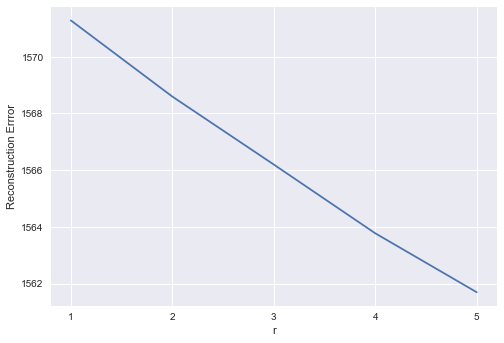

In [30]:
error = [fit_nmf(i) for i in range(1,6)]
plt.plot(range(1,6), error)
plt.xticks(range(1, 6))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

# Random Forest 

In [46]:
clean_df = clean_df.dropna(axis=0)

In [97]:
df_select = clean_df.loc[clean_df['Subreddit'] == 'entertainment']
df_select

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
1306620,wait see whoop intergalact alien butt rogu who...,d02nuw8,movies,entertainment,1.455673e+09,cmonster1697,1.0,0.0,488.0,8426.0,0.0
1306621,amaz cinematograph best ever,d02q51i,movies,entertainment,1.455676e+09,BrodoFagginsIsMyName,1.0,0.0,1.0,457.0,0.0
1306622,final life chang,d02uuym,movies,entertainment,1.455684e+09,BrodoFagginsIsMyName,3.0,0.0,1.0,457.0,0.0
1306623,awesom thank,d02ftgc,movies,entertainment,1.455661e+09,JeopardyThis,3.0,0.0,1.0,-7.0,0.0
1306624,tom cruis charact john anderton kidnap pre-cog...,465qz3,movies,entertainment,1.455672e+09,tangowhiskey33,16.0,0.0,7346.0,6138.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1664682,love,d026lj4,harrypotter,entertainment,1.455648e+09,elbowsss,2.0,0.0,2212.0,8637.0,1.0
1664683,type ra hope manag get select current ras grea...,d02qfaf,harrypotter,entertainment,1.455677e+09,DEP61,2.0,0.0,5581.0,13488.0,0.0
1664684,bulletin board month p http iimgurcom7h3pfuyjpg,d02rem2,harrypotter,entertainment,1.455678e+09,laneebird,2.0,0.0,43.0,8.0,0.0
1664685,excel would pleas find first day great job,d02ecuj,harrypotter,entertainment,1.455659e+09,GoodniteMush,1.0,0.0,1.0,681.0,0.0


In [154]:
X = df_select.drop(['Subreddit', 'ID'], axis =1)
y = df_select['Subreddit']

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

In [152]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=s_stop, max_features =5000 )
vec_X_train = tfidf_vectorizer.fit_transform(X_train)
vec_X_test = tfidf_vectorizer.fit_transform(X_test)

In [153]:
# Train and fit model                                                   
rf = RandomForestClassifier(random_state=0,n_jobs=10, max_features = 'sqrt')

rf.fit(vec_X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(vec_X_test)
print('Accuracy score: {:.3}'.format(rf.score(vec_X_test, y_test)))

Accuracy score: 0.224


In [ ]:
full_class_names = ['entertainment_anime.csv', 'entertainment_comicbooks.csv', 'entertainment_harrypotter.csv', 'entertainment_movies.csv', 'entertainment_music.csv', 'entertainment_starwars.csv', 'gaming_dota2.csv','gaming_gaming.csv', 'gaming_leagueoflegends.csv','gaming_minecraft.csv','gaming_pokemon.csv','gaming_skyrim.csv','gaming_starcraft.csv', 'gaming_tf2.csv','humor_adviceanimals.csv', 'humor_circlejerk.csv', 'humor_facepalm.csv','humor_funny.csv','humor_imgoingtohellforthis.csv','humor_jokes.csv', 'learning_askhistorians.csv','learning_askscience.csv','learning_explainlikeimfive.csv', 'learning_science.csv', 'learning_space.csv', 'learning_todayilearned.csv', 'learning_youshouldknow.csv', 'lifestyle_drunk.csv', 'lifestyle_food.csv', 'lifestyle_frugal.csv', 'lifestyle_guns.csv','lifestyle_lifehacks.csv','lifestyle_motorcycles.csv','lifestyle_progresspics.csv', 'lifestyle_sex.csv','news_conservative.csv','news_conspiracy.csv', 'news_libertarian.csv', 'news_news.csv','news_offbeat.csv','news_politics.csv', 'news_truereddit.csv', 'news_worldnews.csv','television_breakingbad.csv','television_community.csv', 'television_doctorwho.csv', 'television_gameofthrones.csv', 'television_himym.csv', 'television_mylittlepony.csv','television_startrek.csv', 'television_thewalkingdead.csv']


In [135]:
enter_names = ['anime', 'comicbooks', 'harrypotter', 'movies', 'music', 'starwars']



KeyError: 'anime'

In [55]:
s_stop = set(stopwords.words())
print(len(s_stop))
new_stops = ['2015ref','publisherspage190ref','volume9', 'issue2','005', '1671', '2015', 'jpgthumbemerg', 'jpgthumbrightth', 'logo', 'page7','logo.png','2015.ref', 'nameleaf200kcit','ref', '005.jpgthumbrightth', 'whose', 'kind','png', 'jpg', 'wiktionaryzero', 'wiktionaryzero0', 'wiktionaryzero0', 'articlesquantum','0supsup', '0refcit', '1-3', 'redirectzero', '.', ',', 'nameleaf200k2cit', 'wiktionari', 'namecarb01cit','-', 'filezero', 'mvaramvarxmvari', 'page98','datemfyes1915228', 'year1989ref', '1671.jpgthumbemerg', 'refimprovedatemay','ligatureligatur', 'pppc1expiry2144', 'wiktionary','wiktionary0', 'n','improvedateoctob','baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आजक', 'आत', 'आद', 'आफ', 'आय', 'ईक', 'उद', 'उनक', 'उनल', 'उह', 'एउट', 'एन', 'कog', 'कत', 'कम', 'कस', 'कसर', 'कह', 'गत', 'गय', 'गर', 'चम', 'छन', 'जत', 'जबक', 'जस', 'जसक', 'जसब', 'जसम', 'जसल', 'जह', 'तत', 'तथ', 'तदन', 'तप', 'तवम', 'नज', 'नत', 'नभन', 'नय', 'पक', 'पछ', 'पन', 'पय', 'पर', 'पष', 'पह', 'बन', 'बर', 'भएक', 'भय', 'भव', 'मल', 'यत', 'यथ', 'यद', 'यप', 'यसक', 'यसपछ', 'यसब', 'यसर', 'यह', 'रण', 'रत', 'रमश', 'रह', 'लस', 'वर', 'सक', 'सट', 'सध', 'सपछ', 'सब', 'सम', 'सर', 'सह', 'हन', 'हर', 'हरण', 'ἀλλ']
for i in new_stops:
    s_stop.add(i)
    
    
print(len(s_stop))




6255
6471


In [92]:
vectorizer = CountVectorizer(stop_words=s_stop)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
y_train_vec = vectorizer.transform(y_train)
rf = RandomForestClassifier(n_estimators=,
                           max_features='auto',
                           random_state=0,
                           oob_score=True)

rf.fit(X_train_vec, y_train)
rf.oob_score_
# print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
# print("Train Score: ", round(rf.score(X_train_vec,y_train)))
# print("Train Score: ", round(rf.score(X_test_vec,y_test)))
# print("Dic Size:", len(vectorizer.get_feature_names()))

ValueError: Number of labels=1673416 does not match number of samples=10

In [111]:
X = df_select['Text']
y = df_select['meta']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

1306620    entertainment
1306621    entertainment
1306622    entertainment
1306623    entertainment
1306624    entertainment
               ...      
1664682    entertainment
1664683    entertainment
1664684    entertainment
1664685    entertainment
1664686    entertainment
Name: meta, Length: 356493, dtype: object

In [110]:

# train = pd.read_csv('../input/train.csv').fillna(' ')
# test = pd.read_csv('../input/test.csv').fillna(' ')


KeyError: 'Text'

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaimer : i think obama should nominate som...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way the process will be dragged out unt...,d026od6,politics,news,1.455648e+09,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republicans have always battled with severe ca...,d026wk3,politics,news,1.455649e+09,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,politics were so different back then. people o...,d02a3k3,politics,news,1.455653e+09,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,"equally ridiculous , here 's a 1970 law review...",d025wad,politics,news,1.455647e+09,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,for those with a woefully bad sense of directi...,d02c1s1,minecraft,gaming,1.455656e+09,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,the characters hand in first person is invisib...,464kj4,minecraft,gaming,1.455656e+09,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,i guess either the shaders use some feature th...,d02cxvk,minecraft,gaming,1.455657e+09,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,my guess is that you 're trying to use a brand...,d02ic1n,minecraft,gaming,1.455664e+09,nothingl_,1.0,0.0,104.0,807.0,0.0


# EDA and Exploratory Graphs

/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, "Histogram of users' link karma, removed outliers")

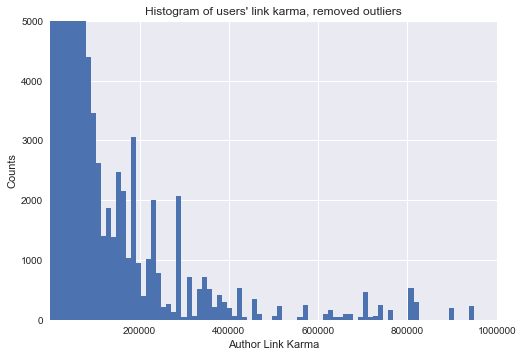

In [194]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
plt.ylim(0, 5000)
plt.xlim(5,1000000)
ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, removed outliers")

Text(0.5, 1.0, "Histogram of users' link karma, yscale log")

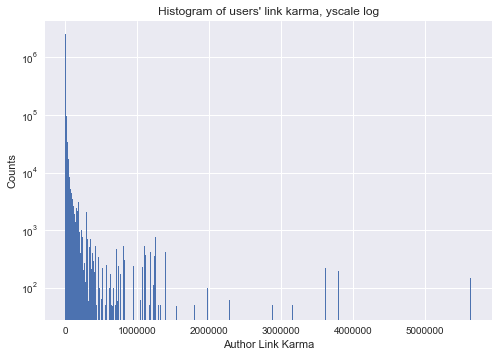

In [195]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
# plt.ylim(0, 5000)
# plt.xlim(5,1000000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, yscale log")

Text(0.5, 1.0, "Histogram of users' link karma, outliers removed yscale log")

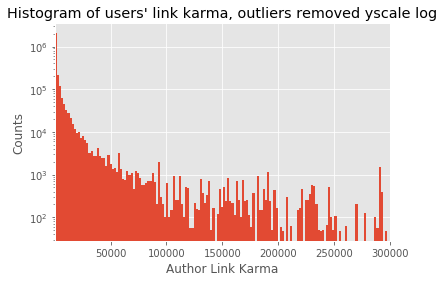

In [160]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 3000)
# plt.ylim()
plt.xlim(1,300000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, outliers removed yscale log")

Text(0.5, 1.0, "Histogram of users' comment karma, removed outliers")

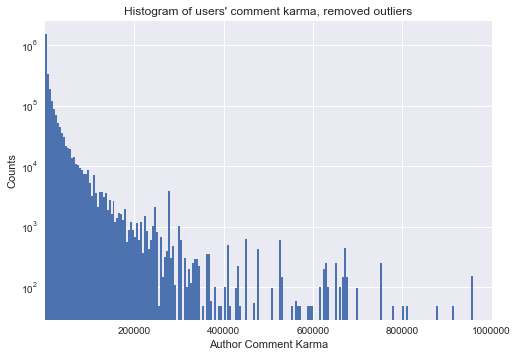

In [204]:
fig, ax = plt.subplots()
plt.hist(df.Author_Comment_Karma, bins = 500)
# plt.ylim(0, 5000)
plt.xlim(1,1000000)

ax.set_yscale('log')
ax.set_xlabel('Author Comment Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' comment karma, removed outliers")

(0, 1500000)

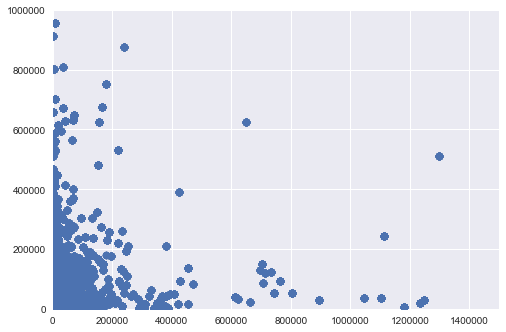

In [207]:
fig, ax = plt.subplots()

plt.scatter(df_test.Author_link_karma, df_test.Author_Comment_Karma)

# ax.set_yscale('')

ax.set_ylim(0, 1000000)
ax.set_xlim(0, 1500000)

Text(0.5, 1.0, 'Histogram of posts per hour of day')

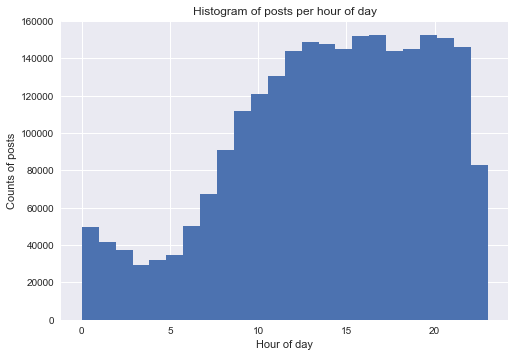

In [192]:
fig, ax = plt.subplots()

plt.hist(df_test.Time.dt.hour, bins = 24)
plt.style.use('seaborn')
ax.set_ylabel('Counts of posts')
ax.set_xlabel('Hour of day')
ax.set_title('Histogram of posts per hour of day')

In [1]:
df_test['Time'].dt.hour

NameError: name 'df_test' is not defined

In [205]:
df_test

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaim think obama nomin someon senat hold c...,d028c5d,politics,news,2016-02-16 13:25:06,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way process drag elect gop vote senat s...,d026od6,politics,news,2016-02-16 12:47:45,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republican alway battl sever case select amnesia,d026wk3,politics,news,2016-02-16 12:52:49,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,polit differ back peopl side least pretend rea...,d02a3k3,politics,news,2016-02-16 14:04:12,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,equal ridicul 1970 law review articl mcconnel ...,d025wad,politics,news,2016-02-16 12:30:13,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,woefulli bad sens direct use advic hand time p...,d02c1s1,minecraft,gaming,2016-02-16 14:46:51,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,charact hand first person invis look glitchi u...,464kj4,minecraft,gaming,2016-02-16 15:01:34,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,guess either shader use featur ad 18 glsl vers...,d02cxvk,minecraft,gaming,2016-02-16 15:06:52,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,guess tri use brand spank new graphic driver n...,d02ic1n,minecraft,gaming,2016-02-16 17:11:31,nothingl_,1.0,0.0,104.0,807.0,0.0


In [ ]:
import itertools

words = clean_df['Text'].str.lower().str.findall("\w+")
words = list(itertools.chain(words))
unique = set(words)
print(unique)